In [1]:
import torch
from torch_geometric.data import Data
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
from torch_geometric.datasets import QM9
import numpy as np
from torch.utils.data import random_split
# import jax
import matplotlib.pyplot as plt
import os

# Define a simple function to convert atom types to atomic numbers
def atom_to_atomic_number(atom):
    mapping = {'H': 1, 'O': 0}
    return mapping.get(atom, 0)


In [2]:
def parse_dataset(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    dataset = []
    i = 0
    while i < len(lines):
        if lines[i].startswith('Energy'):
            # Extract energy
            energy = float(lines[i].split()[-1])
            i += 1  # Move to the next line

            atom_types = []
            positions = []
            while i < len(lines) and not lines[i].startswith('Energy'):
                parts = lines[i].split()
                if len(parts) == 4:  # Ensure the line is for an atom
                    atom_types.append(atom_to_atomic_number(parts[0]))
                    positions.append([float(part) for part in parts[1:]])
                i += 1

            # Convert to PyTorch tensors
            atom_types_tensor = torch.tensor(atom_types, dtype=torch.long)
            positions_tensor = torch.tensor(positions, dtype=torch.float)
            energy_tensor = torch.tensor([energy], dtype=torch.float)

            # Create a Data object
            data = Data(x=atom_types_tensor, pos=positions_tensor, y=energy_tensor)
            dataset.append(data)
        else:
            i += 1  # Skip lines that don't start with 'Energy'

    return dataset

# Load your dataset
dataset = parse_dataset('water-DZ-F12-STATIC-g32n10-3M_PES-DZERO.xyz')


In [3]:
for d in dataset:
    print(d)
    print(d.x)  # Here, d.x is used instead of d.z; you might need to adjust based on your exact needs
    print(d.pos)
    break  # Remove this to loop through the entire dataset


Data(x=[3], y=[1], pos=[3, 3])
tensor([0, 1, 1])
tensor([[ 0.0089,  0.0000,  0.4355],
        [-0.7973,  0.0000, -0.5977],
        [ 0.6555,  0.0000, -0.4876]])


In [4]:
# Now we will do some processing of the data to get into a more usable format. 
# Let’s convert to numpy arrays, remove the partial charges, and convert the elements into one-hot vectors.
def convert_record(d):
    # elements
    e = d.x #.numpy()
    # xyz position
    x = d.pos.numpy() # das hier ist Numpy aber wird später zu tensor (bei x2e)
    # target 
    y = d.y

    # make ohc size larger
    # so use same node feature
    # shape later
    ohc = np.zeros((len(e), 2))
    ohc[np.arange(len(e)), e - 1] = 1
    ohc_tensor = torch.from_numpy(ohc)
    return (ohc_tensor, x), y

for d in dataset:
    (e, x), y = convert_record(d)
    print("Element one hots: \n", e)
    print("tensor size of elements: ", e.size()[0])
    print("Coordinates: \n", x)
    print("Label:", y)
    break

Element one hots: 
 tensor([[0., 1.],
        [1., 0.],
        [1., 0.]], dtype=torch.float64)
tensor size of elements:  3
Coordinates: 
 [[ 0.0089378   0.          0.43550962]
 [-0.79730093  0.         -0.5976605 ]
 [ 0.6554516   0.         -0.48758563]]
Label: tensor([-76.2732])


In [5]:
dataset = torch.utils.data.random_split(dataset, [0.05,0.01,0.01,0.93])
training_set = dataset[0]
test_set = dataset[1]
validation_set = dataset[2]
# dataset[3] = all remaining data

In [6]:
ys = [convert_record(d)[1].numpy() for d in training_set]
train_ym = np.mean(ys)
train_ys = np.std(ys)
print("Mean = ", train_ym, "Std =", train_ys)


def transform_label(y):
    return (y - train_ym) / train_ys


def transform_prediction(y):
    return y * train_ys + train_ym

Mean =  -76.16135 Std = 0.2403025


In [7]:
def x2e(x):
    """convert xyz coordinates to inverse pairwise distance"""
    r2 = np.sum((x - x[:, np.newaxis, :]) ** 2, axis=-1)
    e = np.where(r2 != 0, 1 / r2, 0.0)
    e = torch.from_numpy(e).double()
    return e

print(x2e(x))

tensor([[0.0000, 0.5823, 0.7873],
        [0.5823, 0.0000, 0.4711],
        [0.7873, 0.4711, 0.0000]], dtype=torch.float64)


C:\Users\rotht\AppData\Local\Temp/ipykernel_15900/3558362042.py:4: RuntimeWarning: divide by zero encountered in true_divide
  e = np.where(r2 != 0, 1 / r2, 0.0)


In [8]:
def gnn_layer(nodes, edges, features, we, wb, wv, wu):

    leaky_relu = torch.nn.LeakyReLU(0.01)
    new_nodes_tensor = torch.repeat_interleave(nodes[None, :], nodes.size()[0], dim=0)
    input_tensor = wb + torch.matmul(new_nodes_tensor ,we) * torch.transpose(edges[:,None],1,2)
    ek = leaky_relu(input_tensor)

    # sum over neighbors to get N x features
    ebar = torch.sum(ek, 1)

    # dense layer for new nodes to get N x features
    new_nodes = leaky_relu(torch.matmul(ebar, wv) + nodes)

    # sum over nodes to get shape features
    global_node_features = torch.sum(new_nodes,0)    

    # dense layer for new features
    new_features = leaky_relu(torch.matmul(global_node_features, wu)) + features

    # just return features for ease of use
    return new_nodes, edges, new_features

In [9]:
graph_feature_len = 2
node_feature_len = 2
msg_feature_len = 9

# make our weights as tensors
def init_weights(g, n, m):

    we = torch.nn.Parameter(data=torch.Tensor(n,m).double(), requires_grad=True) 
    we.data.normal_(0,1e-1)
   
    wb = torch.nn.Parameter(data=torch.Tensor(m).double(), requires_grad=True) 
    wb.data.normal_(0,1e-1)

    wv = torch.nn.Parameter(data=torch.Tensor(m,n).double(), requires_grad=True) 
    wv.data.normal_(0,1e-1)

    wu = torch.nn.Parameter(data=torch.Tensor(n,g).double(), requires_grad=True) 
    wu.data.normal_(0,1e-1)
    
    return [we, wb, wv, wu]

# make a graph
nodes = e
edges = x2e(x)
features = np.zeros(graph_feature_len)
features = torch.from_numpy(features).double()

print("nodes: \n", nodes)
print("edges: \n", edges)
print("features: \n", features)

# eval
weights = init_weights(graph_feature_len, node_feature_len, msg_feature_len)
out = gnn_layer(nodes, edges, features, *weights)

# print("weights: \n", weights)
print("input feautres: \n", features)
print("output features: \n", out[2])

nodes: 
 tensor([[0., 1.],
        [1., 0.],
        [1., 0.]], dtype=torch.float64)
edges: 
 tensor([[0.0000, 0.5823, 0.7873],
        [0.5823, 0.0000, 0.4711],
        [0.7873, 0.4711, 0.0000]], dtype=torch.float64)
features: 
 tensor([0., 0.], dtype=torch.float64)
input feautres: 
 tensor([0., 0.], dtype=torch.float64)
output features: 
 tensor([-0.0005,  0.1555], dtype=torch.float64, grad_fn=<AddBackward0>)


C:\Users\rotht\AppData\Local\Temp/ipykernel_15900/3558362042.py:4: RuntimeWarning: divide by zero encountered in true_divide
  e = np.where(r2 != 0, 1 / r2, 0.0)


In [10]:
# get weights for both layers
w1 = init_weights(graph_feature_len, node_feature_len, msg_feature_len)
w2 = init_weights(graph_feature_len, node_feature_len, msg_feature_len) #! ausprobieren, kann sein, dass Variablen überschrieben werden!!!
[we1, wb1, wv1, wu1] = w1
[we2, wb2, wv2, wu2] = w2

w3 = torch.nn.Parameter(data=torch.Tensor(graph_feature_len).double(), requires_grad=True)
w3.data.normal_(0,1)

b = torch.nn.Parameter(data=torch.zeros(1).double(), requires_grad=True) # b wird mit einer Null initialisiert

class Model(nn.Module):
    # funktion für initialisierung hier einbauen

    def __init__(self, w1, w2, w3, b, graph_feature_len): # hier argumente für die layer
        # Gewichte werden hier initialisiert !!! Nicht übergeben
        # hier kann ich gnn_layer klasse aufrufen!
        # self.gnn_layer = # instanz initialisieren
        super(Model, self).__init__()
        self.w1= w1
        self.w2 = w2
        self.w3 = w3
        self.b = b
        self.graph_feature_len = graph_feature_len

    def gnn_layer(self, nodes, edges, features, we, wb, wv, wu): # separate Klasse die auch von nn.module erbt!
        """ Implementation of the GNN
        make nodes be N x N so we can just multiply directly
        ek is now shaped N x N x features """
        # ek = jax.nn.leaky_relu(web + jnp.repeat(nodes[jnp.newaxis, ...], nodes.shape[0], axis=0) @ we * edges[..., jnp.newaxis]
        leaky_relu = torch.nn.LeakyReLU(0.01)
        new_nodes_tensor = torch.repeat_interleave(nodes[None, :], nodes.size()[0], dim=0)
        input_tensor = wb + torch.matmul(new_nodes_tensor ,we) * torch.transpose(edges[:,None],1,2)
        ek = leaky_relu(input_tensor)
        # sum over neighbors to get N x features
        # ebar = jnp.sum(ek, axis=1)
        ebar = torch.sum(ek, 1)
        # dense layer for new nodes to get N x features
        # new_nodes = jax.nn.leaky_relu(ebar @ wv) + nodes
        new_nodes = leaky_relu(torch.matmul(ebar, wv) + nodes)
        # sum over nodes to get shape features
        # global_node_features = jnp.sum(new_nodes, axis=0)   
        global_node_features = torch.sum(new_nodes,0)    
        # dense layer for new features
        # new_features = jax.nn.leaky_relu(global_node_features @ wu) + features
        new_features = leaky_relu(torch.matmul(global_node_features, wu)) + features
        # just return features for ease of use
        return new_nodes, edges, new_features

    def forward(self, nodes, coords):
        f0 = torch.from_numpy(np.zeros(self.graph_feature_len)).double()
        e0 = x2e(coords)
        n0 = nodes
        n1, e1, f1 = gnn_layer(n0, e0, f0, *self.w1)
        n2, e2, f2 = gnn_layer(n1, e1, f1, *self.w2)
        yhat = torch.matmul(f2, self.w3) + self.b
        return yhat

def loss(nodes, coords, y, w1, w2, w3, b):
    return (Model(nodes, coords, w1, w2, w3, b) - y) ** 2

def loss1(nodes, coords, y, w1, w2, w3, b, graph_feature_len):
    model = Model(w1, w2, w3, b, graph_feature_len)
    model.eval()
    prediction = model(nodes, coords)
    return (model(nodes, coords) - y) ** 2

model = Model(w1, w2, w3, b, graph_feature_len)
model.eval()
print(model(nodes, x))

tensor([0.1098], dtype=torch.float64, grad_fn=<AddBackward0>)


C:\Users\rotht\AppData\Local\Temp/ipykernel_15900/3558362042.py:4: RuntimeWarning: divide by zero encountered in true_divide
  e = np.where(r2 != 0, 1 / r2, 0.0)


In [11]:
torch.save(model, os.path.join(os.getcwd(),'water_model.pt'))

In [12]:

optim = torch.optim.Adam([we1, wb1, wv1, wu1, we2, wb2, wv2, wu2, w3, b], lr=1e-3)
# arg1: über welche Parameter optimiert werden soll (Liste mit allen Parametern: *w1,*w2,w3, lr = eta (1e-3))

epochs = 16
eta = 1e-3
val_loss = [0.0 for _ in range(epochs)]
for epoch in range(epochs):
    for d in training_set:
        (e, x), y_raw = convert_record(d)
        y = transform_label(y_raw)
        # originally in jax:
        # grad = loss_grad(e, x, y, w1, w2, w3, b) # defined above in jax
        compute_loss = loss1(e, x, y, w1, w2, w3, b, graph_feature_len) # ursprünglich loss statt loss1
        
        optim.zero_grad() # vor backward gradienten null gesetzt, sonst Akkumulation vom vorherigen Schritt! (exploding/vanishing gradients)
        compute_loss.backward()
        optim.step()
        # * * *

    # compute validation loss
    for v in validation_set:
        (e, x), y_raw = convert_record(v)
        y = transform_label(y_raw)
        # convert SE to RMSE
    val_loss[epoch] += loss1(e, x, y, w1, w2, w3, b, graph_feature_len) # ursprünglich loss statt loss1 !
    val_loss[epoch] = torch.sqrt(val_loss[epoch] / 1000)
    eta *= 0.9

C:\Users\rotht\AppData\Local\Temp/ipykernel_15900/3558362042.py:4: RuntimeWarning: divide by zero encountered in true_divide
  e = np.where(r2 != 0, 1 / r2, 0.0)


In [13]:
torch.save(model.state_dict(), 'water_model_weights.pt')

C:\Users\rotht\AppData\Local\Temp/ipykernel_15900/3558362042.py:4: RuntimeWarning: divide by zero encountered in true_divide
  e = np.where(r2 != 0, 1 / r2, 0.0)


ys:  [tensor([-76.1391]), tensor([-76.2413]), tensor([-75.8920]), tensor([-76.2737]), tensor([-76.2905]), tensor([-76.3117]), tensor([-76.3470]), tensor([-76.2195]), tensor([-76.3028]), tensor([-76.2891]), tensor([-76.2059]), tensor([-76.2785]), tensor([-76.3269]), tensor([-76.3218]), tensor([-76.3249]), tensor([-76.3312]), tensor([-76.2373]), tensor([-76.2835]), tensor([-76.2622]), tensor([-76.2593]), tensor([-76.2471]), tensor([-76.2490]), tensor([-76.1140]), tensor([-75.5222]), tensor([-75.6879]), tensor([-76.2754]), tensor([-75.7625]), tensor([-76.0040]), tensor([-76.2856]), tensor([-76.1749]), tensor([-76.2125]), tensor([-76.2463]), tensor([-76.1570]), tensor([-76.1068]), tensor([-76.1761]), tensor([-76.3001]), tensor([-76.2875]), tensor([-76.2813]), tensor([-76.3200]), tensor([-76.3072]), tensor([-76.2806]), tensor([-76.2430]), tensor([-76.2513]), tensor([-76.2719]), tensor([-76.2362]), tensor([-76.2100]), tensor([-76.2399]), tensor([-76.2407]), tensor([-76.0136]), tensor([-76.27

c:\Python\Python3.9.2\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Python\Python3.9.2\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0, 0.5, 'Predicted Energy')

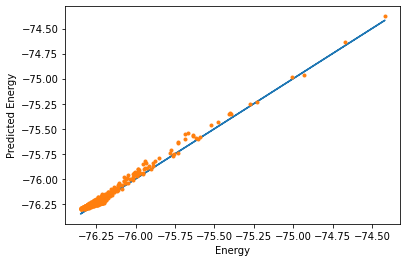

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


ys = []
yhats = []
for v in validation_set:
    (e, x), y = convert_record(v)
    ys.append(y)
    # yhat_raw = Model(e, x, w1, w2, w3, b)
    model = Model(w1, w2, w3, b, graph_feature_len)
    model.eval()
    yhat_raw = model(e, x)
    
    yhats.append(transform_prediction(yhat_raw))


yhats1 = []
for i in yhats:
    i = i.detach().numpy()
    yhats1.append(i)
    
ys_new  = []

for i in ys:
    i = i.detach().numpy()
    ys_new.append(i)
    
print("ys: ", ys)
print("yhats: ", yhats)


mse = mean_squared_error(ys_new, yhats1)
print(f'MSE: {mse}')

rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

r2 = r2_score(ys_new, yhats1)
print("R-squared (R2) Score:", r2)


plt.plot(ys, ys, "-")
plt.plot(ys, yhats1, ".")
plt.xlabel("Energy")
plt.ylabel("Predicted Energy")
# plt.show()